In [3]:
from os import environ
environ["OPENBLAS_NUM_THREADS"] = "1"
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

from matplotlib.path import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
from scipy.spatial import Delaunay, ConvexHull
from scipy.interpolate import griddata

# Local Imports
from crystal_funcs import *
from plotting_utils import *
from TriMap import TriMap


cmap = plt.get_cmap('afmhot').copy()
cmap.set_bad(color='whitesmoke')

$$f_{sym}(x_1, ..., x_n) = \frac{1}{|G|} \sum_{g \in G} f(g\cdot(x_1, ..., x_n))$$

In [4]:
sym_ops = [identity()]

m = [glide_reflection(np.array([1,0,0]), np.zeros(3)),
     glide_reflection(np.array([0,1,0]), np.zeros(3)),
     glide_reflection(np.array([0,0,1]), np.zeros(3))]

rot_order = 3
rot_3fold_1 = [(q_rot_mat(i * 2*np.pi/rot_order, np.array([1, 1, 1])), np.zeros(3)) for i in range(1, rot_order)]
rot_3fold_2 = [(q_rot_mat(i * 2*np.pi/rot_order, np.array([1, -1, 1])), np.zeros(3)) for i in range(1, rot_order)]
rot_3fold_3 = [(q_rot_mat(i * 2*np.pi/rot_order, np.array([-1, 1, 1])), np.zeros(3)) for i in range(1, rot_order)]
rot_3fold_4 = [(q_rot_mat(i * 2*np.pi/rot_order, np.array([-1, -1, 1])), np.zeros(3)) for i in range(1, rot_order)]

rot_order = 2
rot_2fold_x = [(q_rot_mat(i*2*np.pi/rot_order, np.array([1, 0, 0])), np.zeros(3)) for i in range(1, rot_order)]
rot_2fold_y = [(q_rot_mat(i*2*np.pi/rot_order, np.array([0, 1, 0])), np.zeros(3)) for i in range(1, rot_order)]
rot_2fold_z = [(q_rot_mat(i*2*np.pi/rot_order, np.array([0, 0, 1])), np.zeros(3)) for i in range(1, rot_order)]


sym_ops += m
sym_ops += rot_2fold_x + rot_2fold_y + rot_2fold_z
sym_ops += rot_3fold_1 + rot_3fold_2 + rot_3fold_3 + rot_3fold_4

sym_ops.append(identity(inversion=True))

print_symmetry_operations(sym_ops)

Rotation/Reflection Matrix:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
 [0. 0. 0.]
------------------------------
Rotation/Reflection Matrix:
 [[-1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
Translation Vector:
 [0. 0. 0.]
------------------------------
Rotation/Reflection Matrix:
 [[ 1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0.  1.]]
Translation Vector:
 [0. 0. 0.]
------------------------------
Rotation/Reflection Matrix:
 [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0. -1.]]
Translation Vector:
 [0. 0. 0.]
------------------------------
Rotation/Reflection Matrix:
 [[ 1.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.0000000e+00 -1.2246468e-16]
 [ 0.0000000e+00  1.2246468e-16 -1.0000000e+00]]
Translation Vector:
 [0. 0. 0.]
------------------------------
Rotation/Reflection Matrix:
 [[-1.0000000e+00  0.0000000e+00  1.2246468e-16]
 [ 0.0000000e+00  1.0000000e+00  0.0000000e+00]
 [-1.2246468e-16  0.0000000e+00 -1.0000000e+00]]
Translation Vector:
 [0. 0. 0.]
--------------

2D
----
***

In [22]:
def func6(*xi):
    x,y = xi
    return x**6 + x**5*y + x**4*y**2 + x**3*y**3 + x**2*y**4 + x*y**5 + y**6

def func5(*xi):
    x,y = xi
    return x**5 + x**4*y + x**3*y**2 + x**2*y**3 + x*y**4 + y**7

def func4(*xi):
    x,y = xi
    return x**4 + x**3*y + x**2*y**2 + x*y**4 + y**7

def func3(*xi):
    x,y = xi
    return x**3 + x**2*y + x*y**2 + y**5

def func2(*xi):
    x,y = xi
    return np.cos(2*np.pi*x**2) + np.sin(np.pi*y**2)

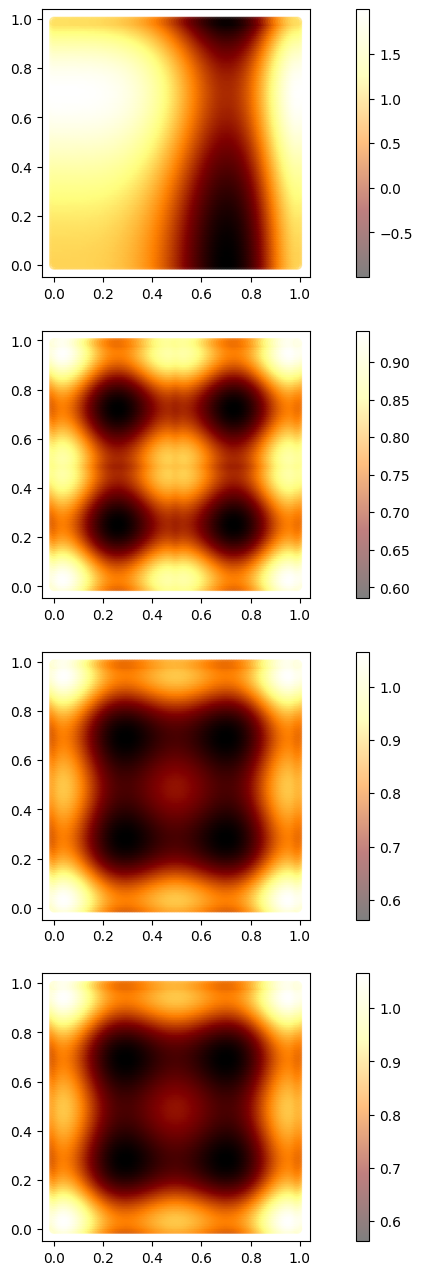

In [23]:
ndim = 2
domain = np.array([(0, 1)]*ndim)
center = 0.5 * (domain[:,1] - domain[:,0])


N=99
xi = np.array([np.linspace(d[0], d[1], N, endpoint=False) for d in domain]) - center[:, None]
grid = np.meshgrid(*xi)
coords = np.vstack([x.ravel() for x in grid]).T + center

# Group operations
# Rotations & Identity
rot_order = 4
p4 = [(rot_mat(i * 2*np.pi/rot_order), np.zeros(2)) for i in range(rot_order)]

# Glide Reflections
g =[(np.array([[-1, 0], [0,  1]]), center),
    (np.array([[1,  0], [0, -1]]), center),
    (np.array([[0,  1], [1,  0]]), center),
    (np.array([[0, -1], [-1, 0]]), center)]

# Reflections
m = [(np.array([[1,  0], [0, -1]]), np.zeros(2)),
     (np.array([[-1, 0], [0,  1]]), np.zeros(2)),
     (np.array([[0,  1], [1,  0]]), np.zeros(2)),
     (np.array([[0, -1], [-1, 0]]), np.zeros(2))]

plot_names = ['original', 'p4gm', 'p4mm', 'p411']

plot_func(func2,*grid,center=center, sym_ops=[[*p4, *g, *m], [*p4, *m], [*p4]])

fundamental_units = [np.array([(0.5,0),(0.5,0.5),(0,0.5)]),
                     np.array([(0.5,0),(0.5,0.5),(0,0.5)]),
                     np.array([(0.5,0),(0.5,0.5),(0,0)]),
                     np.array([(0.5,0),(0.5,0.5),(0,0.5)])]

dirichlet_points = np.random.dirichlet([1.5,1.5,1.5], 50000)
dirichlet_weights = barycentric_weights(dirichlet_points)
n_samples=1000



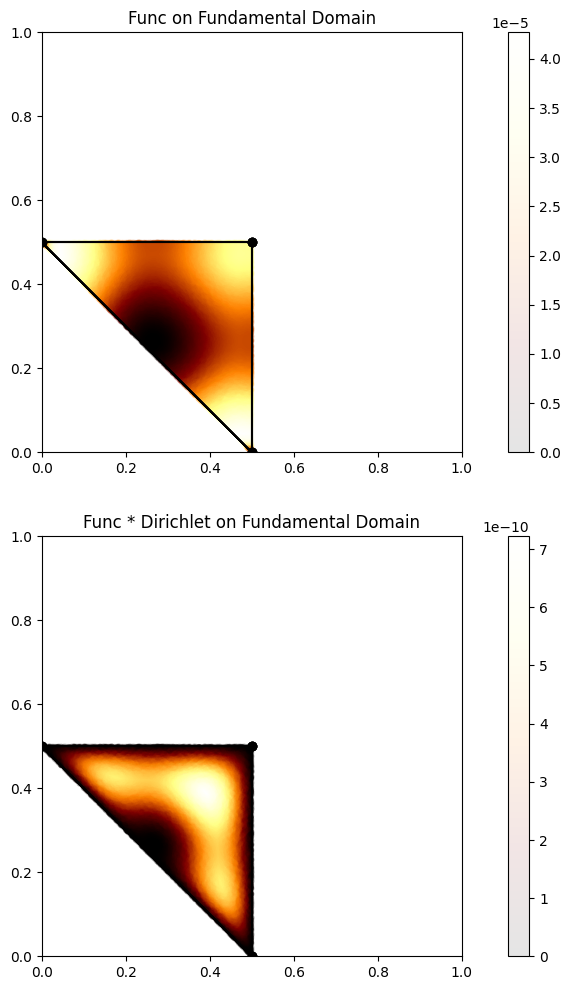

In [26]:
test_unit = np.array([(0.5,0),(0.5,0.5),(0,0.5)])
polygon = np.array([(1.00, 0.00), (0.62, 0.78), (-0.22, 1), (-0.90, 0.2), (-0.90, -0.43), (-0.22, -0.97), (0.62, -0.78)])
n_samples=50000
f_sym = symmetrize(func2, *grid, sym_ops=[*p4, *g, *m])
# distribution, distribution_weights = plot_weighted_distribution(f_sym, coords, test_unit, n_samples=n_samples, alpha=[1,1,1])
plot_weighted_dist(f_sym, coords.T, test_unit, n_samples=n_samples)

11


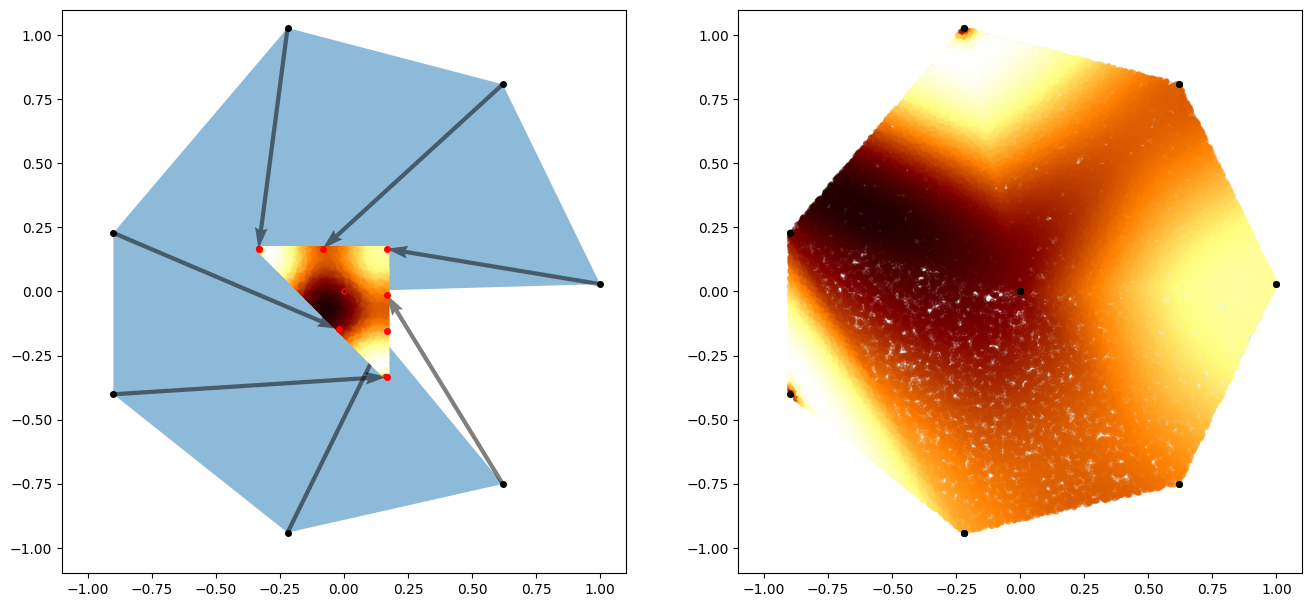

In [27]:
distribution, distribution_weights = weighted_distribution(f_sym, coords.T, test_unit, n_samples=n_samples)
distribution -= centroid(test_unit)
map = TriMap(polygon, test_unit)
map.define_distribution(distribution=barycentric_coordinates2D(distribution, test_unit), distribution_weights=distribution_weights)
out = map.create_mapping()
idx = map.minimize_jacobian()
print(idx)
plot_result(map, idx)

In [28]:
best_poly = map.rotated_polygons[idx]
best_poly_cropped = best_poly[:-1]
edges = []
for i in range(len(best_poly_cropped)):
    edges.append(edge_func(best_poly_cropped[i], best_poly_cropped[(i+1)%len(best_poly_cropped)]))
edges = np.vstack(edges)
source_points = np.vstack([edges] +list(best_poly))


best_map = map.maps[idx]
best_map_cropped = best_map[:-1]
edges = []
for i in range(len(best_map_cropped)):
    edges.append(edge_func(best_map_cropped[i], best_map_cropped[(i+1)%len(best_map_cropped)]))
edges = np.vstack(edges)
target_points = np.vstack([edges] +list(best_map))


_, src_idx = np.unique(source_points, axis=0, return_index=True)
source_points = source_points[src_idx]
target_points = target_points[src_idx]

_, dst_idx = np.unique(target_points, axis=0, return_index=True)
source_points = source_points[dst_idx]
target_points = target_points[dst_idx]


max_deg = 10
dist = barycentric_to_cartesian_2D(map.distribution, map.triangle)
dist_x, dist_y = dist[:,0], dist[:,1]
# map from triangle to polygon
coeffs_x, coeffs_y = compute_coefficients(target_points, source_points, max_deg)
inv_basis = polynomial_basis(dist_x, dist_y, max_deg)
# u, v = np.sum(coeffs_x * inv_basis.T, axis=1), np.sum(coeffs_y * inv_basis.T, axis=1)
nonlinear_map = np.vstack((np.sum(coeffs_x * inv_basis.T, axis=1),
                           np.sum(coeffs_y * inv_basis.T, axis=1))).T



inv_mats = np.array([np.linalg.inv(M) for M in map.matrices[idx]])
dst_idxs = get_triangles(best_map, dist)
affine_map = np.array([apply_transformation(pt, inv_mats[i]) for pt, i in zip(dist, dst_idxs)])


In [29]:
def weighting(x, alpha):
    return np.exp(-alpha * x)
print(best_poly)
lines_start = best_poly
lines_end = np.roll(best_poly, -1, axis=0)
distances = dist_to_line(dist, lines_start, lines_end)
distances /= np.max(distances)
w = weighting(np.min(distances, axis=0), 6)
mapped_pts = ((1-w) * nonlinear_map.T + (w) * affine_map.T).T

[[ 1.          0.02857143]
 [ 0.62        0.80857143]
 [-0.22        1.02857143]
 [-0.9         0.22857143]
 [-0.9        -0.40142857]
 [-0.22       -0.94142857]
 [ 0.62       -0.75142857]
 [ 0.          0.        ]]


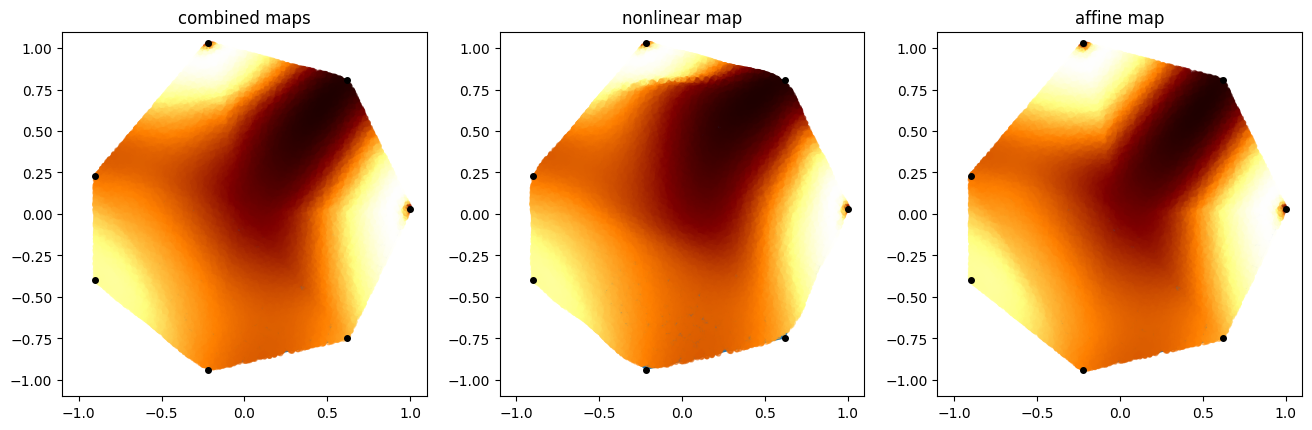

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(16, 16))
plot_polygon(best_poly_cropped, ax[0])
plot_polygon(best_poly_cropped, ax[1])
plot_polygon(best_poly_cropped, ax[2])
ax[0].set_title("combined maps")
ax[0].scatter(mapped_pts[:,0], 
              mapped_pts[:,1], 
              s=10, 
              c=map.distribution_weights, 
              cmap=cmap, 
              alpha=0.5)
ax[1].set_title("nonlinear map")
ax[1].scatter(nonlinear_map[:,0], 
              nonlinear_map[:,1], 
              s=10, 
              c=map.distribution_weights, 
              cmap=cmap, 
              alpha=0.5)
ax[2].set_title("affine map")
ax[2].scatter(affine_map[:,0], 
              affine_map[:,1], 
              s=10, 
              c=map.distribution_weights, 
              cmap=cmap, 
              alpha=0.5)
plt.show()

3D
----
***

In [9]:
def func3D(*xi):
    x,y,z = xi
    return np.cos(2*np.pi*x**2) + np.sin(np.pi*y**2) + np.cos(2*np.pi*z**2) 

def func3D2(*xi):
    x,y,z = xi
    return np.sin(2 * np.pi * x) * np.sin(2 * np.pi * y) * np.sin(2 * np.pi * z)

def func_sin(*xi, n):
    """
    """
    return np.prod([np.sin(2 * np.pi / n * x) for x in xi], axis=0)

def func_cos(*xi, n):
    """
    """
    return np.prod([np.cos(2 * np.pi / n * x) for x in xi], axis=0)

(50, 50, 50)


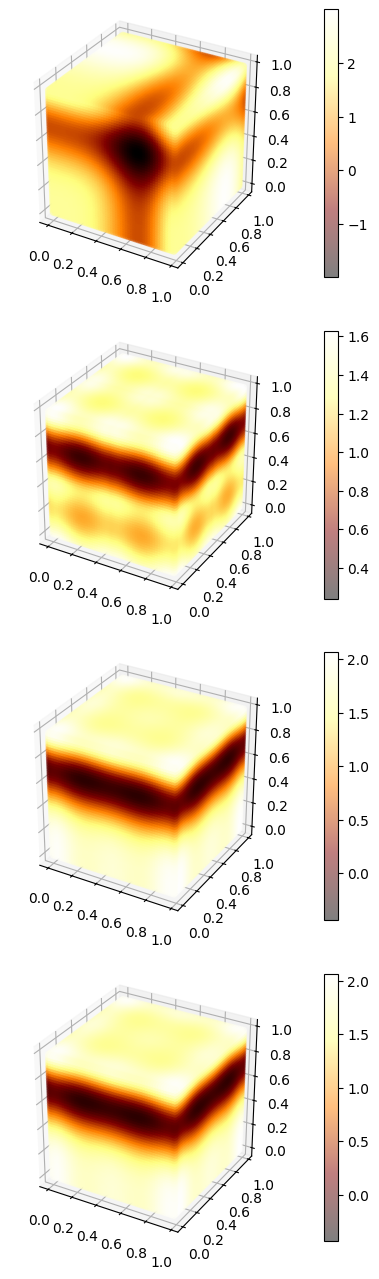

In [10]:
ndim = 3
domain = np.array([(0, 1)]*ndim)
center = 0.5 * (domain[:,1] - domain[:,0])

N=50
xi = np.array([np.linspace(d[0], d[1], N, endpoint=False) for d in domain]) - center[:, None]
grid = np.meshgrid(*xi)
print(grid[0].shape)
coords = np.vstack([x.ravel() for x in grid]).T + center

rot_order = 4
axis = np.array([0,0,1])
p4 = [(q_rot_mat(i * 2*np.pi/rot_order, axis), np.zeros(3)) for i in range(1, rot_order)]

p4.append(identity())
# Glide Reflections
g =[glide_reflection(np.array([1,0,0]), center),
    glide_reflection(np.array([0,1,0]), center),
    glide_reflection(np.array([1,-1,0]), center),
    glide_reflection(np.array([1,1,0]), center)]

# Reflections
m = [glide_reflection(np.array([1,0,0]), np.zeros(3)),
     glide_reflection(np.array([0,1,0]), np.zeros(3)),
     glide_reflection(np.array([1,-1,0]), np.zeros(3)),
     glide_reflection(np.array([1,1,0]), np.zeros(3))]

plot_func(func3D, *grid, center=center, sym_ops=[[*p4, *g, *m], [*p4, *m], [*p4]])

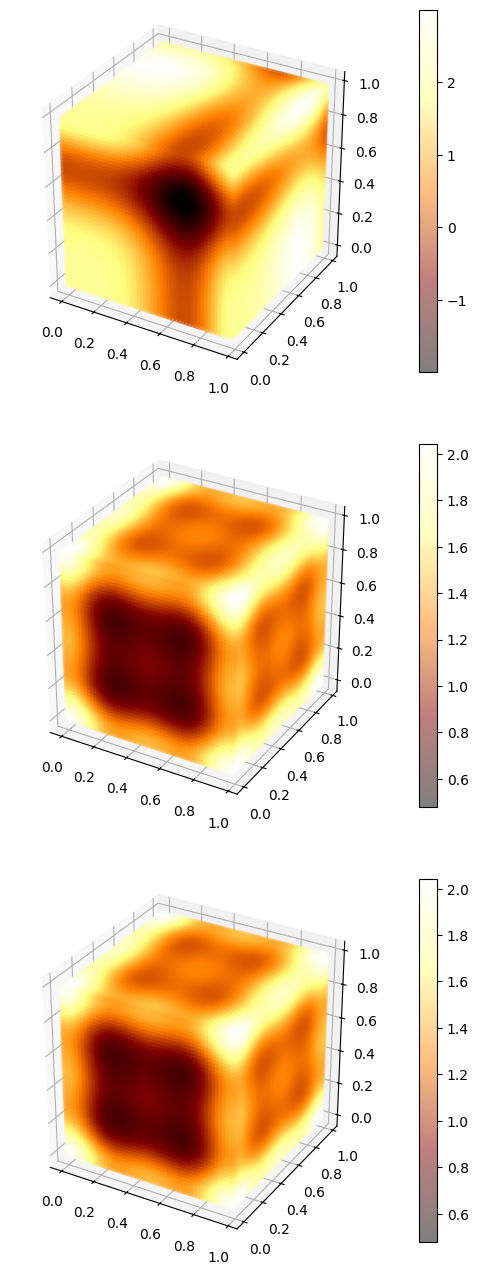

In [11]:
sym_ops = [identity()]

m = [glide_reflection(np.array([1,0,0]), np.zeros(3)),
     glide_reflection(np.array([0,1,0]), np.zeros(3)),
     glide_reflection(np.array([0,0,1]), np.zeros(3))]

rot_order = 3
rot_3fold_1 = [(q_rot_mat(i * 2*np.pi/rot_order, np.array([1, 1, 1])), np.zeros(3)) for i in range(1, rot_order)]
rot_3fold_2 = [(q_rot_mat(i * 2*np.pi/rot_order, np.array([1, -1, 1])), np.zeros(3)) for i in range(1, rot_order)]
rot_3fold_3 = [(q_rot_mat(i * 2*np.pi/rot_order, np.array([-1, 1, 1])), np.zeros(3)) for i in range(1, rot_order)]
rot_3fold_4 = [(q_rot_mat(i * 2*np.pi/rot_order, np.array([-1, -1, 1])), np.zeros(3)) for i in range(1, rot_order)]

rot_order = 2
rot_2fold_x = [(q_rot_mat(i*2*np.pi/rot_order, np.array([1, 0, 0])), np.zeros(3)) for i in range(1, rot_order)]
rot_2fold_y = [(q_rot_mat(i*2*np.pi/rot_order, np.array([0, 1, 0])), np.zeros(3)) for i in range(1, rot_order)]
rot_2fold_z = [(q_rot_mat(i*2*np.pi/rot_order, np.array([0, 0, 1])), np.zeros(3)) for i in range(1, rot_order)]


sym_ops += m
sym_ops += rot_2fold_x + rot_2fold_y + rot_2fold_z
sym_ops += rot_3fold_1 + rot_3fold_2 + rot_3fold_3 + rot_3fold_4

sym_ops.append(identity(inversion=True))
plot_func(func3D, *grid, center=center, sym_ops=[sym_ops, sym_ops])

In [12]:
polyhedron = np.array([[0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [1, 0, 1], [0, 1, 1], [1, 1, 1]], dtype=np.float64)
polyhedron -= polyhedron_centroid(polyhedron)
polyhedron -= polyhedron_centroid(polyhedron)
polyhedron = scale_poly(polyhedron)
ply_w_center = np.array(list(polyhedron) + [polyhedron_centroid(polyhedron)])
# polyhedron in barycentric coordinates wrt tetrahedron


tetra = np.array([[0, 0, 0], 
                  [0.5, 0, 0], 
                  [0, 0.5, 0], 
                  [0, 0, 0.5]])

ply_bary = calculate_barycentric_coordinates(tetra, polyhedron)

ply_map = np.zeros(polyhedron.shape)
ply_map_w_center = np.zeros((polyhedron.shape[0]+1, *polyhedron.shape[1:]))

f_sym = symmetrize(func3D, *grid, sym_ops=sym_ops)
alpha = 0.9*np.ones(4)

In [13]:
tetra = scale_poly(tetra)
print(tetra)
dist, dist_weights = weighted_distribution(f_sym, coords.T, tetra, n_samples=n_samples)
# dir_points = calculate_barycentric_coordinates(tetra, dist)
# dir_weights = barycentric_weights(dir_points)
# dir_weights /= np.sum(dir_weights)
# dist_weights *= dir_weights

[[0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


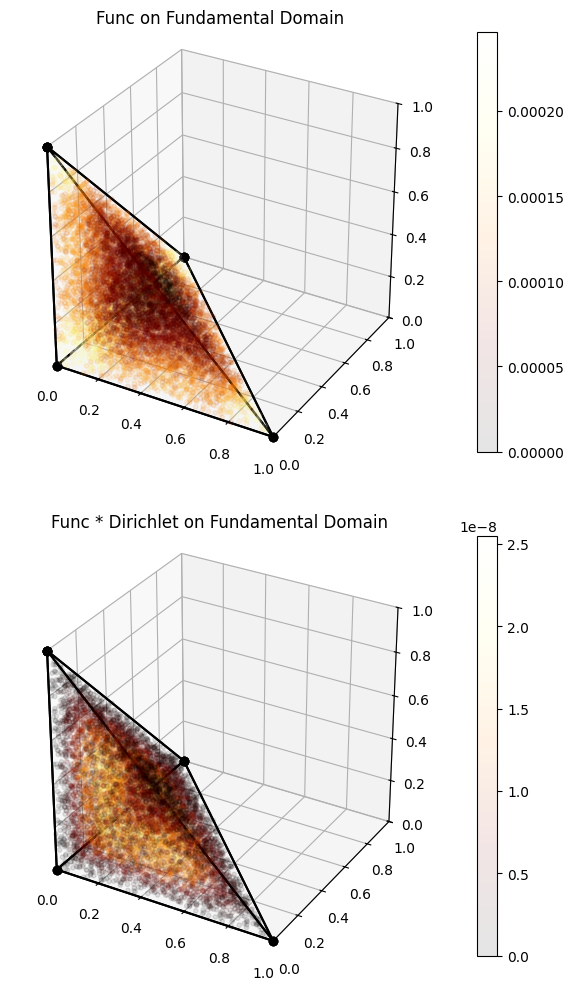

In [14]:
n_samples=10000
plot_weighted_dist(f_sym, coords.T, tetra, n_samples=n_samples)

Mapping
----
***

In [15]:
cent = simplex_centroid(tetra)
tetra -= cent
dist -= cent

# tetra = scale_poly(tetra)
piecewise_matrices, triangulations, simps, dst, src = collect_matrices(tetra, polyhedron, num_rots=12)

print(len(piecewise_matrices), len(triangulations), len(src), len(dst))
min_idx = minimize_jacobian(piecewise_matrices, dst, simps, src)
print(min_idx)
best_mat, best_map, best_tri, best_poly = piecewise_matrices[min_idx], dst[min_idx], triangulations[min_idx], src[min_idx]

10080 10080 10080 10080
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
singular matrices
sing

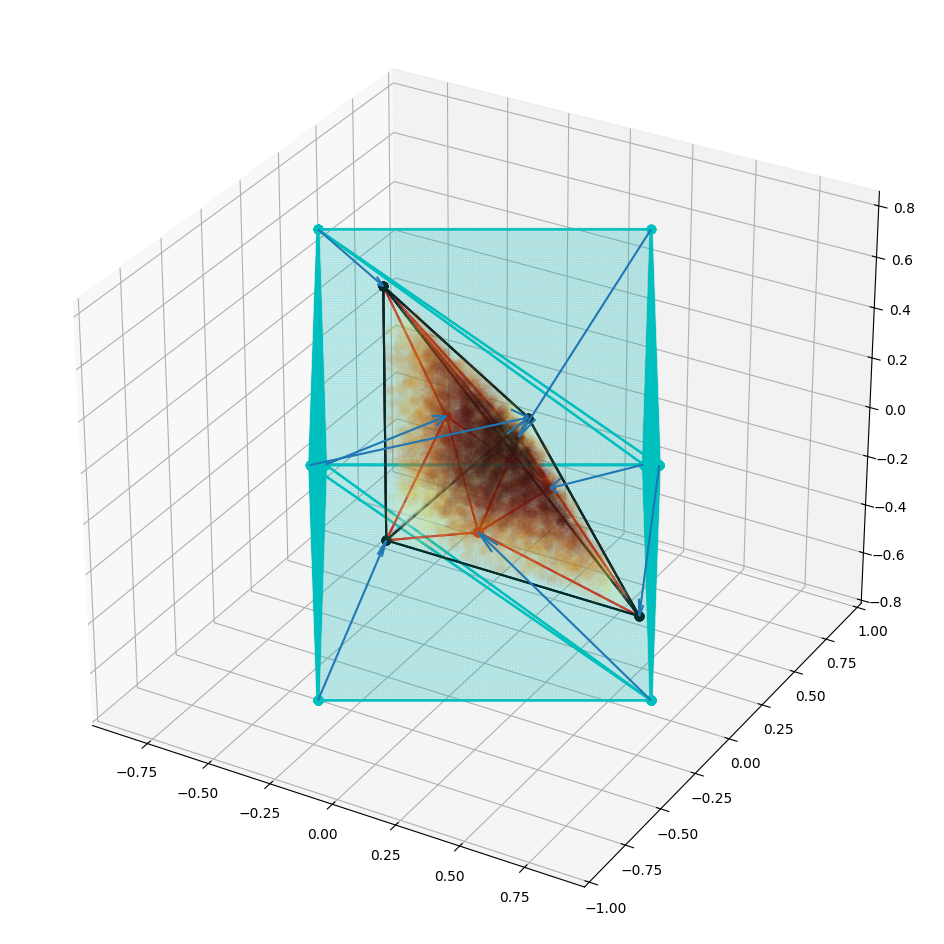

In [16]:
fig = plt.figure(figsize=(12,12))
ax:Axes3D = fig.add_subplot(111, projection='3d')

ax.scatter(*dist.T, c=dist_weights, s=50, cmap=cmap, alpha=0.05, edgecolors='none', linewidths=0)

for tet in best_tri.simplices:
    faces = ConvexHull(best_map[tet]).simplices
    plot_simplex(best_poly, ax, simplices=faces, color='c', linestyle='')   
    plot_simplex(best_map, ax, simplices=faces, color='c', linestyle='')   

plot_simplex(best_poly, ax, color='c', show_faces=True)
plot_simplex(best_map, ax, simplices=ConvexHull(best_poly).simplices, color='r')    
plot_simplex(best_map, ax, color='k')

end_pts = best_map-best_poly
ax.quiver(*best_poly.T, *end_pts.T, length=1, arrow_length_ratio=0.1)
ax.set_aspect('equal')

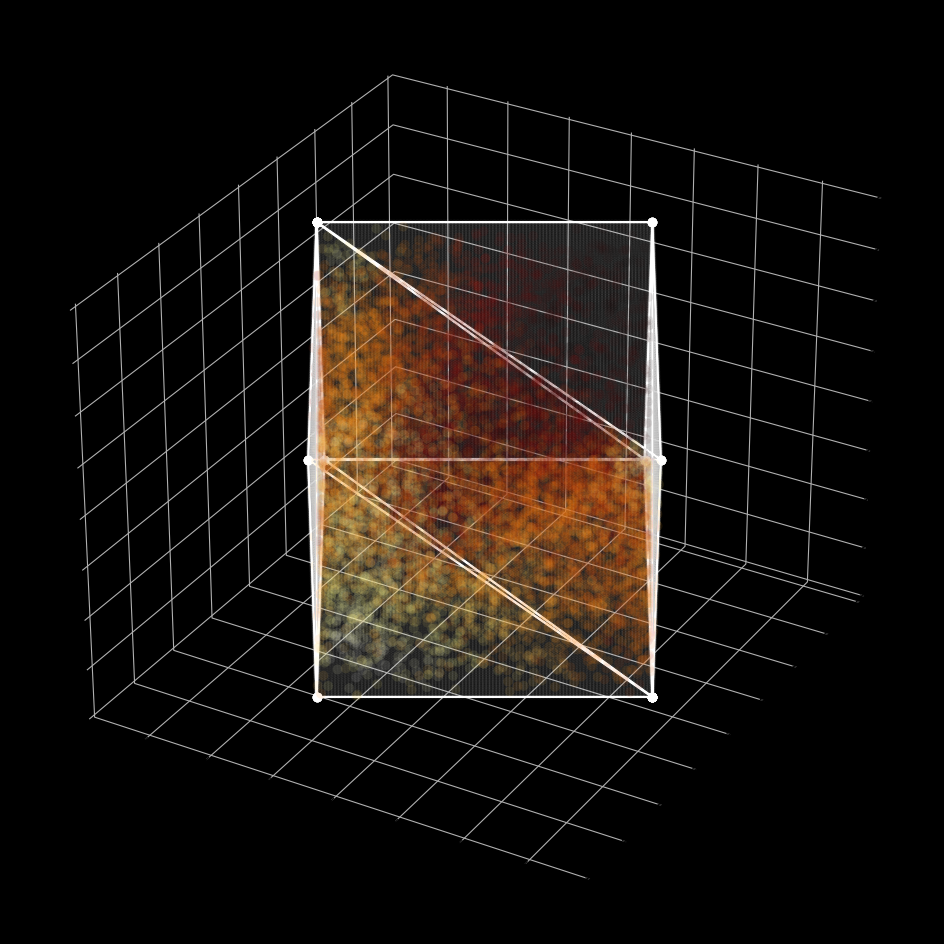

In [17]:
#353
# alpha = 0.9*np.ones(4)
# dir_points_bary = np.random.dirichlet(alpha, 50000)
# dir_points_cart = bary_to_cart(dir_points_bary, tetra)
# bary_weights = np.prod(dir_points_bary, axis=-1)
inv_mats = np.array([np.linalg.inv(M) for M in best_mat])


fig = plt.figure(figsize=(12,12))
fig.patch.set_facecolor('black')
ax:Axes3D = fig.add_subplot(111, projection='3d')
ax.set_facecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
dst_idxs = best_tri.find_simplex(dist)
affine_map = np.array([apply_transformation(pt, inv_mats[idx]) for pt, idx in zip(dist, dst_idxs)])
# ax.scatter(*affine_map.T, c=bary_weights, s=50, cmap=cmap, edgecolors='none', linewidths=0)
ax.scatter(*affine_map.T, c=dist_weights, s=50, cmap=cmap, alpha=0.1, edgecolors='none', linewidths=0)

faces = ConvexHull(best_poly).simplices
for face in faces:
    vs = np.array(list(best_poly[face]) + [best_poly[face][0]])
    ax.plot(*vs.T, 'wo-')
    parametrization = parametrize_triangle(*best_poly[face], num_points=100)
    ax.scatter(*parametrization.T, c='w', s=10, alpha=0.025)


ax.set_aspect('equal')
ax.set_proj_type('persp')
# ax.view_init(0,0,0)

In [ ]:
def weighting(x, alpha):
    return np.exp(-alpha * x)
print(best_poly)
lines_start = best_poly
lines_end = np.roll(best_poly, -1, axis=0)
distances = dist_to_line(dist, lines_start, lines_end)
distances /= np.max(distances)
w = weighting(np.min(distances, axis=0), 6)
mapped_pts = ((1-w) * nonlinear_map.T + (w) * affine_map.T).T

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 16))
plot_polygon(best_poly_cropped, ax[0])
plot_polygon(best_poly_cropped, ax[1])
plot_polygon(best_poly_cropped, ax[2])
ax[0].scatter(mapped_pts[:,0], 
              mapped_pts[:,1], 
              s=10, 
              c=map.distribution_weights, 
              cmap='viridis', 
              alpha=0.9)
ax[1].scatter(nonlinear_map[:,0], 
              nonlinear_map[:,1], 
              s=10, 
              c=map.distribution_weights, 
              cmap='viridis', 
              alpha=0.9)
ax[2].scatter(affine_map[:,0], 
              affine_map[:,1], 
              s=10, 
              c=map.distribution_weights, 
              cmap='viridis', 
              alpha=0.9)
plt.show()

Old
----
***













In [ ]:
def plot_weighted_distribution(f_sym:np.ndarray, X:np.ndarray, Y:np.ndarray, triangle, n_samples=50000, alpha=[1,1,1]):
    coordinates = np.vstack([X.ravel(), Y.ravel()]).T
    # Generate Dirichlet distributed points within the triangle
    dir_points = np.random.dirichlet(alpha, n_samples)
    dir_points_cart = barycentric_to_cartesian_2D(dir_points, triangle)
    dir_weights = barycentric_weights(dir_points)
    dir_weights /= np.sum(dir_weights)
    # Get only the coordinates inside the fundamental unit
    
    """mask = is_inside_triangle(coordinates, triangle)
    coords_inside = coordinates[mask]"""


    """# Get value of f_symm and the dirichlet distribution at each point inside the triangle
    f_values = f_sym.ravel()[mask]
    f_values /= np.sum(f_values)
    
    distances = np.linalg.norm(dir_points_cart[:, np.newaxis, :] - coords_inside, axis=2)
    
    # print(distances.shape)
    closest_point_indices = np.argmin(distances, axis=0)
    # Array of weights of the same shape as coordinates -> one weight at each coordinate
    weight_sums = np.bincount(closest_point_indices, minlength=dir_points_cart.shape[0])
    f_weights = np.bincount(closest_point_indices, weights=f_values, minlength=dir_points_cart.shape[0])
    # mean value of dirichlet weight at each coordinate
    filtered_f = f_weights[weight_sums > 0]
    filtered_f /= weight_sums[weight_sums > 0]
    # norm to 1
    filtered_f /= np.sum(filtered_f)
    """
    kde = gaussian_kde([coordinates[:, 0], coordinates[:, 1]], weights=f_sym.ravel())
    sampled_f = kde([dir_points_cart[:, 0], dir_points_cart[:,1]])
    sampled_f /= np.sum(sampled_f)
    f_values_min = np.min(sampled_f)
    f_values_max = np.max(sampled_f)
    f_sampled_normalized = (sampled_f - f_values_min) / (f_values_max - f_values_min)
    f_sampled_normalized /= np.sum(f_sampled_normalized)
    
    # gmm = GaussianMixture(n_components=4, max_iter=1000)
    # probabilities = f_sym.ravel()**2
    # probabilities /= np.sum(probabilities)
    # dist = np.random.choice(len(coordinates), size=n_samples, p=probabilities)
    # gmm.fit(coordinates[dist])
    # samples, _ = gmm.sample(n_samples)
    # inside_samples = samples[isinside(samples, triangle)]

    # gmm = GaussianMixture(n_components=4, max_iter=1000)
    # probabilities = f_sym.ravel()**2
    # probabilities /= np.sum(probabilities)
    # dist = np.random.choice(len(coordinates), size=100000, p=probabilities)
    # gmm.fit(coordinates[dist])
    # samples, _ = gmm.sample(100000)
    # distances = np.linalg.norm(coordinates[:, np.newaxis, :] - samples, axis=2)
    # closest_point_indices = np.argmin(distances, axis=0)
    
    # sample_weights = np.bincount(closest_point_indices, minlength=coordinates.shape[0])
    # sample_weights = sample_weights.astype(float)/ np.sum(sample_weights.astype(float))
    
    f_values_at_dir_points = griddata(coordinates, f_sym.ravel(), dir_points_cart, method='linear')
    f_values_at_dir_points /= np.sum(f_values_at_dir_points)
    f_values_min = np.min(f_values_at_dir_points)
    f_values_max = np.max(f_values_at_dir_points)
    f_values_normalized = (f_values_at_dir_points - f_values_min) / (f_values_max - f_values_min)
    f_values_normalized /= np.sum(f_values_normalized)
    probabilities = f_values_normalized * dir_weights

    # dir_weights = dir_weights[weight_sums > 0]
    
    # # We can now weight f_values according to dir_weights
    # probabilities = filtered_f**10 * dir_weights
    # probabilities = probabilities/np.sum(probabilities)
    # dir_points_cart=dir_points_cart[weight_sums > 0]



    # plot
    plt.figure(figsize=(8, 6))
    plt.scatter(dir_points_cart[:,0], dir_points_cart[:,1], 
                c=f_sampled_normalized* dir_weights,
                alpha=0.5,
                s=5)
    plt.colorbar(label='Weighted Distribution')
    plt.xlim(-0, 1)
    plt.ylim(-0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.scatter(dir_points_cart[:,0], dir_points_cart[:,1], 
                c=f_values_normalized* dir_weights,
                alpha=0.5,
                s=5)
    plt.colorbar(label='Weighted Distribution')
    plt.xlim(-0, 1)
    plt.ylim(-0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.scatter(dir_points_cart[:,0], dir_points_cart[:,1], 
                c=dir_weights,
                alpha=0.5,
                s=5)
    plt.colorbar(label='Weighted Distribution')
    plt.xlim(-0, 1)
    plt.ylim(-0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    return dir_points_cart - centroid(triangle), probabilities

In [ ]:
def plot_weighted_distribution(f_sym:np.ndarray, X:np.ndarray, Y:np.ndarray, triangle, n_samples=50000, alpha=[1,1,1]):
    coordinates = np.vstack([X.ravel(), Y.ravel()]).T
    # Generate Dirichlet distributed points within the triangle
    dir_points = np.random.dirichlet(alpha, n_samples)
    dir_points_cart = barycentric_to_cartesian_2D(dir_points, triangle)
    dir_weights = barycentric_weights(dir_points)
    dir_weights /= np.sum(dir_weights)
    
    f_weights = f_sym.ravel()/np.sum(f_sym.ravel())
    kde = gaussian_kde([coordinates[:, 0], coordinates[:, 1]], weights=f_weights, bw_method=0.05)
    sampled_f = kde([dir_points_cart[:, 0], dir_points_cart[:,1]])
    sampled_f /= np.sum(sampled_f)
    f_values_min = np.min(sampled_f)
    f_values_max = np.max(sampled_f)
    f_sampled_normalized = (sampled_f - f_values_min) / (f_values_max - f_values_min)
    f_sampled_normalized /= np.sum(f_sampled_normalized)
    
    
    f_values_at_dir_points = griddata(coordinates, f_weights, dir_points_cart, method='linear')
    f_values_at_dir_points /= np.sum(f_values_at_dir_points)
    f_values_min = np.min(f_values_at_dir_points)
    f_values_max = np.max(f_values_at_dir_points)
    f_values_normalized = (f_values_at_dir_points - f_values_min) / (f_values_max - f_values_min)
    f_values_normalized /= np.sum(f_values_normalized)
    probabilities = f_values_normalized * dir_weights

    plt.figure(figsize=(8, 6))
    plt.scatter(dir_points_cart[:,0], dir_points_cart[:,1], 
                c=f_sampled_normalized * dir_weights,
                alpha=0.5,
                s=5)
    plt.colorbar(label='Weighted Distribution')
    plt.xlim(-0, 1)
    plt.ylim(-0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.scatter(dir_points_cart[:,0], dir_points_cart[:,1], 
                c=f_values_normalized * dir_weights,
                alpha=0.5,
                s=5)
    plt.colorbar(label='Weighted Distribution')
    plt.xlim(-0, 1)
    plt.ylim(-0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.scatter(dir_points_cart[:,0], dir_points_cart[:,1], 
                c=dir_weights,
                alpha=0.5,
                s=5)
    plt.colorbar(label='Weighted Distribution')
    plt.xlim(-0, 1)
    plt.ylim(-0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    return dir_points_cart - centroid(triangle), probabilities

In [ ]:
tetra -= simplex_centroid(tetra)
tetra = scale_poly(tetra)



num_rots=12
mats = generate_rotation_matrices(num_rots)
rotations = rotate_polyhedron(ply_w_center, mats)
combos = unique_tuples(polyhedron.shape[0], 4)
piecewise_matrices, dst, triangulations, src, simps= [], [], [], [], []
for combo in combos:
    rotated_tetras = rotations[:, combo, :]
    mask = np.ones(ply_w_center.shape[0], dtype=bool)
    mask[combo] = False
    mask[-1] = False
    others = rotations[:, mask, :]
    dst_pts = np.zeros_like(rotations)
    dst_pts[:, combo, :] = tetra

    bary_others = np.array([calculate_barycentric_coordinates(tetra, rot) for rot in others])
    # Should I do abs. val of 
    closest_face = np.argsort(bary_others, axis=-1)[:,:, -3:]
    
    rows = np.arange(others.shape[0])[:, None, None]
    # cols = np.arange(others.shape[2])[None, None, :]
    faces = tetra[closest_face]
    faces_poly = rotated_tetras[rows, closest_face]
    interped_pts = np.array([interpolate_to_plane(pts, 
                                                  tetra_face[:,0], tetra_face[:,1], tetra_face[:,2], 
                                                  poly_face[:, 0], poly_face[:, 1], poly_face[:, 2]) 
                                                  for pts, tetra_face, poly_face in zip(others, faces, faces_poly)])
    dst_pts[:, mask, :] = interped_pts

    # furthest_vert = np.argmin(bary_others, axis=-1)
    # rows = np.arange(bary_others.shape[0])[:, None]
    # cols = np.arange(bary_others.shape[1])[None, :]
    # bary_others[rows, cols, furthest_vert] = 0
    # bary_others /= np.sum(bary_others, axis=-1, keepdims=True)
    # cartpts = np.array([bary_to_cart(rot, tetra) for rot in bary_others])
    # dst_pts[:, mask, :] = cartpts

    tri_poly_dst = [Delaunay(pt) for pt in dst_pts]
    tris = [Delaunay(pt).simplices for pt in dst_pts]
    triangulations.extend(tri_poly_dst)
    simps.extend(tris)
    dst.extend(list(dst_pts.copy()))
    src.extend(list(rotations.copy()))
    piecewise_matrices.extend([create_piecewise_matrices(src_pt, dst_pt, tri) for src_pt, dst_pt, tri in zip(rotations, dst_pts, tris)])
